In [2]:
using Flux, CUDA, Adapt, CMBLensing, PyPlot, LinearAlgebra, ProgressMeter, Setfield

In [3]:
Flux.use_cuda[] = false

false

In [4]:
storage = Flux.use_cuda[] ? CuArray : Array;

In [5]:
@unpack f, n, ϕ, ds = load_sim(; storage, Nside=64, θpix=2, pol=:I, μKarcminT=150, seed=0, bandpass_mask=LowPass(3000));
fwf = argmaxf_lnP(I, (;), @set(ds.Cf=ds.Cf̃));


In [6]:
M = Diagonal(adapt(storage, make_mask(f, edge_padding_deg=0.2, apodization_deg=0.2, edge_rounding_deg=0.1, num_ptsrcs=0)))
noM = ones((64,64,1,1))

64×64×1×1 Array{Float64,4}:
[:, :, 1, 1] =
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  

In [7]:
plot(
    [
        f   ds.d;
        fwf out
    ],
    title=["truth" "data"; "WF" "NN"]
)

LoadError: [91mUndefVarError: out not defined[39m

In [27]:
begin
	tuple_identity(a) = identity(a)
	tuple_identity(a...) = tuple(a...)
	cat3(a,b) = cat(a,b;dims=3)
    
	function tuplecat3(a::Tuple{AbstractArray,AbstractArray},b::Tuple{AbstractArray,AbstractArray}) 
       # println(size(a[1]),size(a[2]), size(b[1]), size(b[2]))
        (cat3(a[1],b[1]), cat3(a[2],b[2]))
    end
    
    
    #deprecated
	tuplecat3(a::Tuple{Int64,Int64},b::Tuple{Int64,Int64}) = a .+ b
    
    #both deprecated? see comment in WNBB
	identity_dims(a...;b...) = tuple(a...)
	WNBB_dims(a,b;Nfeatures=10) = (Nfeatures, Nfeatures + b)
end

WNBB_dims (generic function with 1 method)

In [8]:
begin
	function QuadSemiLinear((lin,nonlin)::Tuple{AbstractArray,AbstractArray})
    #this might be super duper slow?
		nl = size(lin,3)
		nnl = size(nonlin,3)
		layers = [selectdim(lin,3,i:i) .* selectdim(nonlin,3,j:j) for i in 1:nl for j in 1:nnl]
		for k in 1:nl
			push!(layers,selectdim(lin,3,k:k))
		end
		#println(size(reduce(cat3, layers)))
		return (reduce(cat3, layers), nonlin)
	end

	QuadSemiLinear(lin::AbstractArray,nonlin::AbstractArray) = QuadSemiLinear((lin,nonlin))
	QuadSemiLinear(a::Int64,b::Int64) = (a*b+a, b)
	
	function QuadSemiLinearConv(input_features, channels_out)
		a,b = input_features
		Chain(QuadSemiLinear, Parallel(tuple, Conv((1,1), a*(b+1)=>channels_out; stride=1, pad=SamePad()), identity))
	end

		
	
end

QuadSemiLinearConv (generic function with 1 method)

In [36]:
begin
    function printdims(x::Tuple)
        println(size(x[1]), size(x[2]))
        return x
    end
	function WienerNetBaseBlock(input_features, inner, inner_dims; Nfeatures=10)
		## a function (linear,nonlinear) -> (linear,nonlinear) 
		## that encodes the basic building block of WienerNet

        # replace with simple boolean inner ? (Nf,Nf) : (Nf,2Nf)
		inner_features = inner_dims(Nfeatures, Nfeatures; Nfeatures)
		skip_features = (2Nfeatures, Nfeatures+input_features[2])
		Chain(
		QuadSemiLinearConv(input_features, Nfeatures),
		SkipConnection(
			Chain(
				Parallel(
					tuple,
					Conv((5,5), Nfeatures=>Nfeatures, stride=2, pad=SamePad()),
					Conv((5,5), input_features[2]=>Nfeatures, relu; stride=2, pad=SamePad()),
					),
				inner, 
     #           printdims,
				Parallel(
					tuple,
					ConvTranspose((5,5), inner_features[1]=>Nfeatures, stride=2, pad=SamePad()),
					ConvTranspose((5,5), inner_features[2]=>Nfeatures, relu; stride=2, pad=SamePad()),
					)
				),
			tuplecat3),
		QuadSemiLinearConv(skip_features, Nfeatures)
		)
	end
end

WienerNetBaseBlock (generic function with 1 method)

In [37]:
begin
	wn = WienerNetBaseBlock((10,10), identity, identity_dims)
	wn = WienerNetBaseBlock((10,10), wn, WNBB_dims)
	wn = WienerNetBaseBlock((10,10), wn, WNBB_dims)
	wn = WienerNetBaseBlock((10,10), wn, WNBB_dims)
	#wn = WienerNetBaseBlock((10,10), wn, WNBB_dims)
	#wn = WienerNetBaseBlock((10,10), wn, WNBB_dims)

    
    # feed input, extract output
	wn = Chain(Parallel(tuple,
			Conv((5,5), 1=>10; stride=1, pad=SamePad()),
			Conv((5,5), 1=>10; stride=1, pad=SamePad())),
			wn,
			((a,b),) -> a, 
			ConvTranspose((5,5), 10=>1; stride=1, pad=SamePad())
		)
    wn = Flux.gpu(wn)
    model(x::Tuple{AbstractArray,AbstractArray}) = wn((Float32.(x[1]), Float32.(x[2])))
    model(x::AbstractArray) = wn((Float32.(x), ones(Float32, size(x))[:,:,:,:]))
    model(f::Field) = FlatMap(wn((Float32.(f[:Ix][:,:,:,:]), ones(Float32, size(f[:Ix]))[:,:,:,:]))[:,:,1,1], f.metadata)
	
end

model (generic function with 3 methods)

In [45]:
dfs = @showprogress map(1:32) do i
    @unpack d,f,f̃ = resimulate(ds,seed=i)
    d[:Ix][:,:,:,:], f̃[:Ix][:,:,:,:]
end;

xs = cat(first.(dfs)..., dims=4)
ys = cat(last.(dfs)...,  dims=4)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


64×64×1×32 Array{Float32,4}:
[:, :, 1, 1] =
 -114.325   -133.283   -112.567   …  -60.0696   -72.2448   -88.2172
 -136.253   -156.256   -135.743      -60.2187   -75.9614  -103.807
 -155.978   -168.841   -145.228      -62.2614   -90.1259  -124.279
 -161.221   -158.409   -126.532      -81.115   -113.824   -142.364
 -145.668   -131.606   -100.408      -97.2308  -126.182   -145.121
 -113.981    -95.7973   -76.3937  …  -99.1034  -119.624   -127.006
  -74.4627   -57.7003   -46.9492     -88.0686   -96.6816   -92.9989
  -34.8396   -25.6915   -24.4402     -63.1055   -64.3068   -52.9458
  -15.8612   -19.4428   -22.3309     -36.7432   -33.1188   -23.7276
  -26.2305   -33.0071   -33.794      -27.4685   -23.271    -22.2903
  -58.3228   -61.4232   -51.2888  …  -42.3977   -40.8758   -48.688
  -82.3751   -80.9962   -64.7224     -69.6759   -65.4487   -73.5722
  -83.327    -82.6999   -72.0186     -78.0084   -72.9888   -77.4508
    ⋮                             ⋱                       
  -78.2451   -75.09

In [12]:
loss_J2(x,d) = Flux.mse(model(x), d);
function loss_J3(x, d)
    y = FlatMap(model(x), f.metadata)
    Δ = ds.M * ds.B * y - FlatMap(d, f.metadata)
    sum(unbatch(Δ' * pinv(ds.Cn) * Δ + y' * pinv(ds.Cf̃) * y))
end

loss_J3 (generic function with 1 method)

In [ ]:
opt = ADAM(1e-3)

@showprogress for i=1:10
    Flux.Optimise.train!(loss_J2, params(wn), [(xs,ys)], opt);
end

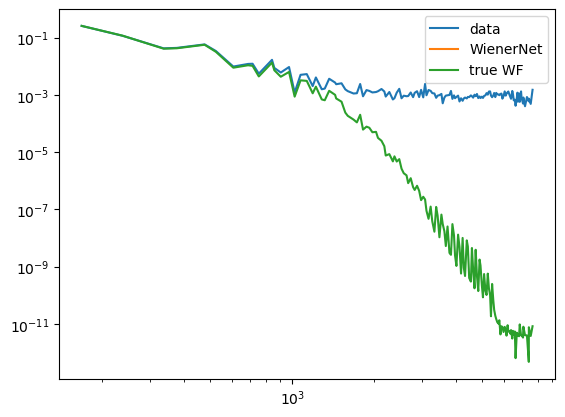

PyObject <matplotlib.legend.Legend object at 0x2b58536597d0>

In [30]:
loglog(get_Cℓ(M*ds.d), label="data")
loglog(get_Cℓ(M*model(ds.d)), label="WienerNet")
loglog(get_Cℓ(M*fwf), label="true WF")
legend()

In [47]:
rand128() = Float32.(reshape(rand(128*128), (128,128,1,1)))
rand100() = Float32.(reshape(rand(100*100), (100,100,1,1)))

rand100 (generic function with 1 method)

In [38]:
reduce(+, (reduce(*, size(pa)) for pa in params(wn)))

69711

In [44]:
params(wn)[2]

10-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0